# Cluster Analysis of Trimmed Spectrogram (CATS)

# False alarm filtering via multi-station analysis:
- Association, Voting, Interpolation, and Extrapolation

In [1]:
import numpy as np
import numba as nb
import holoviews as hv

from scipy import signal, special, optimize, stats
import ssqueezepy as ssq
import timeit
import pyskbel as api
import xarray as xr
import os

In [2]:
import cats

<hr>

In [3]:
N_datasets = 25

# i = np.random.choice(N_datasets)
i = 2
folder = "C:/Users/seraf/OneDrive - ualberta.ca/Documents/WaveDatasets/GeneratedData"
Dclean = api.compose_from_meta(f"{folder}/MetaDataSetsNew/dataset_{i}_main.pkl", 
                               noise=0.0, data_path=f'{folder}/SurfaceEvents')
Dclean = np.moveaxis(Dclean, -1, 1)
main_meta = api.utils.read_dict(f"{folder}/MetaDataSetsNew/dataset_{i}_main.pkl")
main_meta['data_path'] = 'C:\\Users\\seraf\\OneDrive - ualberta.ca\\Documents\\WaveDatasets\\GeneratedData\\SurfaceEvents'

x = np.linspace(main_meta['xmin'], main_meta['xmax'], main_meta['nx'])
time = np.linspace(main_meta['Tmin'], main_meta['Tmax'], main_meta['nT'])
dt = main_meta['dt']

t1, t2 = 8, 22
it1, it2 = int(t1 / dt), int(t2 / dt)
time = time[it1 : it2 + 1]
time -= time.min()
Dclean = Dclean[..., it1 : it2 + 1]

Taper on axis = -2 is applied


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
beta = 0
noise_ids = {-1 : "high_freq", 0 : "white", 1 : "low_freq"}
noise_id = noise_ids[beta]
Noise = api.utils.get_noise((0.05, beta), Dclean.shape, axis=2)
Noise += 0.07 * np.sin(time * 2 * np.pi * 50)[None, None, :]
D = Dclean + Noise

eps = 0.007
true_detection_time = abs(Dclean) > eps
Srms = np.sqrt(np.mean(Dclean[true_detection_time]**2))
Nrms = np.sqrt(np.mean(Noise**2))
print("SNR = ", Srms**2 / Nrms**2)
print("Noise color = ", noise_id)

SNR =  1.0607335157843574
Noise color =  white


In [18]:
catsdet = cats.CATSDetector(dt_sec=dt,
                            stft_window_sec=('hann', 0.15),
                            stft_overlap=0.5,
                            stft_nfft=256,
                            minSNR=4.0,
                            stationary_frame_sec=1.0,
                            cluster_size_t_sec=0.2,
                            cluster_size_f_Hz=8.,
                            cluster_distance_t_sec=0.2,
                            cluster_distance_f_Hz=2.,
                            min_t_separation_sec=0.0,
                            clustering_with_SNR=True,
                            clustering_multitrace=True,
                            cluster_size_trace=2,
                            cluster_distance_trace=2,
                            date_Q=0.95,
                            date_detection_mode=True,
                            stft_backend='ssqueezepy')
print(f"{catsdet.stationary_frame_len = }")
print(f"{catsdet.min_t_separation_len = }")
print(f"{catsdet.cluster_size_t_len = }")
print(f"{catsdet.cluster_size_f_len = }")
print(f"{catsdet.cluster_distance_t_len = }")
print(f"{catsdet.cluster_distance_f_len = }")
print(f"{catsdet.min_t_separation_len = }")

catsdet.stationary_frame_len = 256
catsdet.min_t_separation_len = 0
catsdet.cluster_size_t_len = 2
catsdet.cluster_size_f_len = 4
catsdet.cluster_distance_t_len = 2
catsdet.cluster_distance_f_len = 1
catsdet.min_t_separation_len = 0


:Curve   [Frequency]   (y)
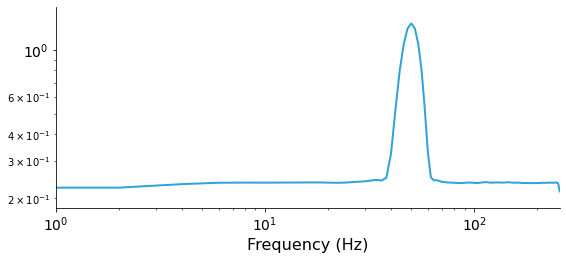

In [6]:
noise_psd = abs(catsdet.STFT * Noise).mean(axis=(0, 1, 3))
f_dim = hv.Dimension('Frequency', unit='Hz')
fontsize = dict(labels=16, ticks=14)
fig_noise_psd = hv.Curve((catsdet.stft_frequency, noise_psd), 
                         kdims=f_dim).opts(fig_size=250, aspect=2.5, logx=True, 
                                           fontsize=fontsize, ylabel='', 
                                           logy=True, xlim=(1, np.nan))
# hv.save(fig_noise_psd, f"figures/NoisePSD_{noise_id}.png", dpi=300)
fig_noise_psd

In [19]:
t_start = timeit.default_timer()

catsres = catsdet.detect(D)

t_delta = timeit.default_timer() - t_start
print(f"{t_delta = : .3f} seconds")
print(f"1 Terabyte = {t_delta * (1024**4 / D.nbytes ) / 3_600 : .2f} hours")

t_delta =  0.721 seconds
1 Terabyte =  10.08 hours


:Layout
   .Curve.A_0_full_stop_Input_data_colon_x_n                                                                                                                                                                                     :Curve   [Time]   (Amplitude)
   .Image.A_1_full_stop_Spectrogram_colon_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line                                                                                                         :Image   [Time,Frequency]   (z)
   .Image.A_2_full_stop_Trimming_by_B_hyphen_minus_E_hyphen_minus_DATE_colon_B_left_curly_bracket_k_comma_m_right_curly_bracket_reverse_over_cdot_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line :Image   [Time,Frequency]   (z)
   .Image.A_3_full_stop_Clustering_colon_C_left_curly_bracket_k_comma_m_right_curly_bracket_reverse_over_cdot_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line                                     :Image   [Time,Frequency]   (z)
   .Curve.A_4_full_stop_Projection_colon_o_k                                                                                                                                                                                     :Curve   [Time]   (Classification)
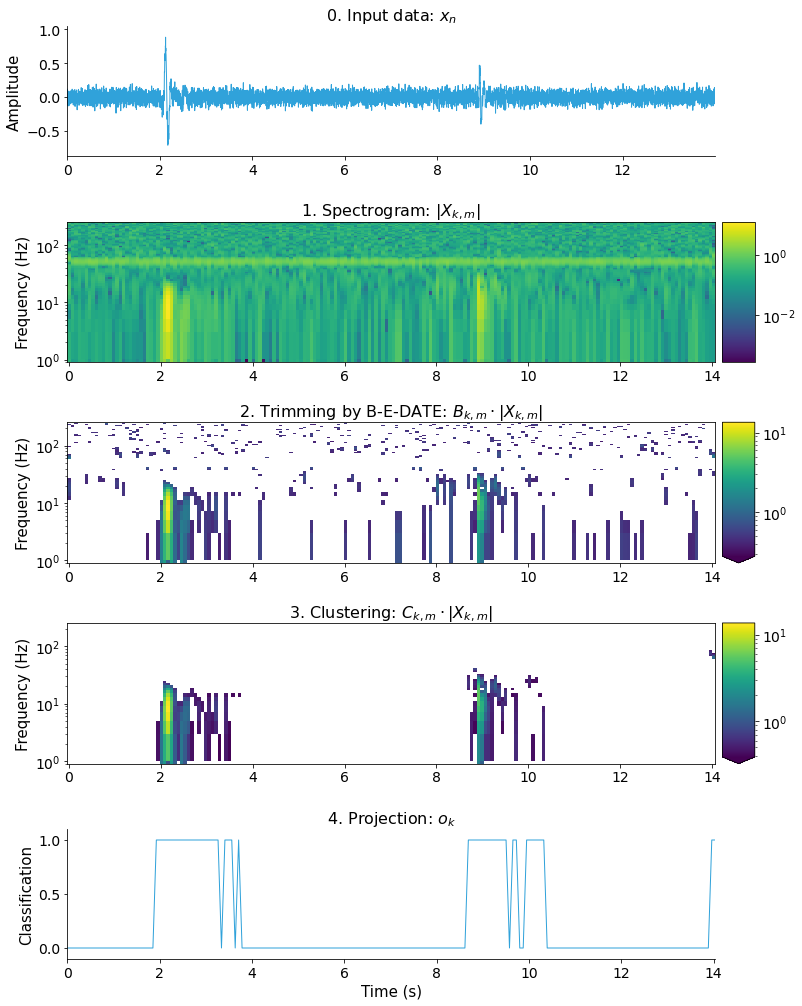

In [20]:
comp = 'Z'
comps = {'X' : 0, 'Y' : 1, 'Z': 2}
ind = (50, comps[comp])
fig = catsres.plot(ind).cols(1)
xlim = (np.nan, np.nan)
fig.opts(hv.opts.Curve(xlim=xlim, linewidth=1), 
         hv.opts.Image(xlim=xlim, logz=True, ylim=(0.9, np.nan)))
# hv.save(fig, f'../figures/synthetic_demo_{comp}_{noise_id}.png', dpi=300)
fig

:Image   [x,y]   (z)
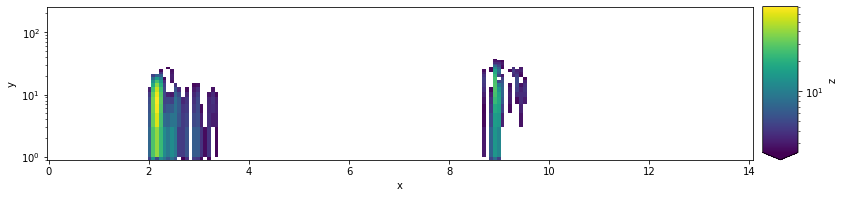

In [8]:
SNRK = catsres.SNR_spectrogram[ind] * catsres.binary_spectrogram_clustered[ind]
hv.Image((catsres.stft_time, catsres.stft_frequency, SNRK)).opts(aspect=2, logy=True, logz=True, fig_size=350, 
                                                                 cmap='viridis', ylim=(0.9, np.nan), colorbar=True)

In [9]:
print("Mean SNR: ", (catsres.SNR_spectrogram[catsres.binary_spectrogram_clustered]).mean())
print("Median SNR: ", np.median(catsres.SNR_spectrogram[catsres.binary_spectrogram_clustered]))

Mean SNR:  6.342575379225355
Median SNR:  3.877634869482963


:Curve   [Time]   (Amplitude)
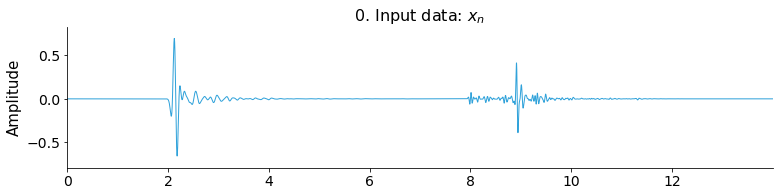

In [136]:
comp = 'Z'
comps = {'X' : 0, 'Y' : 1, 'Z': 2}
ind = (comps[comp], 50)
fig = catsres.plot(ind).cols(1)
fig[0].data.Amplitude = Dclean[ind]
fig[0].opts(linewidth=1, fig_size=350)
# hv.save(fig[0], f"../figures/synthetic_demo_{comp}_clean.png", dpi=300)
fig[0]

In [10]:
eps = 0.007
binary_cmap = ['white', 'blue']
binary_cticks = [(0, 'Noise'), (1, 'Event')]
fontsize = dict(labels=16, ticks=15)
image_kwargs = dict(colorbar=True, aspect=3.5, fontsize=fontsize, 
                    cmap=binary_cmap, cbar_ticks=binary_cticks,
                    clabel='', xlabel='Time (s)', ylabel='Location (km)',
                    fig_size=400, clim=(-0.5, 1.5))

true_detection_time = abs(Dclean) > eps
stft_time = catsdet.STFT.forward_time_axis(len(time))
true_detection = cats.core.projection.ProjectFilterIntervals(true_detection_time, time, 1, 0.5, stft_time)
# hv.Image((stft_time, x, true_detection.max(0))).opts(**image_kwargs)
# hv.Image((catsres.stft_time, x, catsres.detection.max(0))).opts(**image_kwargs)

In [11]:
fp_max = int(0.5 / catsdet.stft_hop_sec)
labels, R = cats.EvaluateDetection(true_detection.max(1), catsres.detection.max(1), 
                                   0.9, fp_max)
report = "True Positive = {0}\tFalse Positive = {1}\nTrue Negative = {2}\tFalse Negative = {3}"
print(report.format(R[..., 1].sum(), R[..., 2].sum(), R[..., 3].sum(), R[..., 0].sum()))

True Positive = 220	False Positive = 163
True Negative = 368	False Negative = 34


In [12]:
class_cmap = ['red', 'white', 'blue', 'green']
class_cticks = [(-1, 'Missed'), (0, 'Noise'), (1, 'Detected'), (2, 'False Alarm')]
fontsize = dict(labels=16, ticks=15)
cl_image_kwargs = dict(colorbar=True, aspect=3.5, fontsize=fontsize, 
                    cmap=class_cmap, cbar_ticks=class_cticks, clim=(-1.5, 2.5),
                    clabel='', xlabel='Time (s)', ylabel='Location (km)',
                    fig_size=400)

fig = hv.Image((catsres.stft_time, x, labels)).opts(**cl_image_kwargs)
# fig

In [13]:
data_meta = dict(dims=["Location", "Component", "Time"], 
                 coords={"Component" : ['X', 'Y', 'Z'],
                         "Location" : x,
                         "Time" : time})

traces = {'Synthetic' : xr.DataArray(D, **data_meta)}
traces_clean = {'Synthetic' : xr.DataArray(Dclean, **data_meta)}
#################
det_meta = dict(dims=["Location", "Component", "Time"], 
                 coords={"Component" : ['X', 'Y', 'Z'],
                         "Location" : x,
                         "Time" : catsres.stft_time})

detection_pred = {'Synthetic' : xr.DataArray(catsres.detection, **det_meta)}                          
detection_true = {'Synthetic' : xr.DataArray(true_detection, **det_meta)}

label_meta = dict(dims=["Location", "Component", "Time", "Class"], 
                 coords={"Component" : ['X', 'Y', 'Z'],
                         "Location" : x,
                         "Time" : catsres.stft_time, 
                         "Class" : ['TP', 'FP', 'FN']})

labels, R = cats.EvaluateDetection(true_detection, catsres.detection, 
                                   0.9, fp_max)
class_labels = np.stack([labels == 1, labels == 2, labels == -1], axis=-1)

detection_labels = {'Synthetic' : xr.DataArray(class_labels, **label_meta)}

print(report.format(R[..., 1].sum(), R[..., 2].sum(), R[..., 3].sum(), R[..., 0].sum()))

True Positive = 437	False Positive = 1276
True Negative = 1669	False Negative = 71


:Overlay
   .Curve.I             :Curve   [Time]   (y)
   .Curve.II            :Curve   [Time]   (y)
   .Curve.III           :Curve   [Time]   (y)
   .Curve.IV            :Curve   [Time]   (y)
   .Curve.V             :Curve   [Time]   (y)
   .Curve.VI            :Curve   [Time]   (y)
   .Curve.VII           :Curve   [Time]   (y)
   .Curve.VIII          :Curve   [Time]   (y)
   .Curve.IX            :Curve   [Time]   (y)
   .Curve.X             :Curve   [Time]   (y)
   .Curve.XI            :Curve   [Time]   (y)
   .Curve.XII           :Curve   [Time]   (y)
   .Curve.XIII          :Curve   [Time]   (y)
   .Curve.XIV           :Curve   [Time]   (y)
   .Curve.XV            :Curve   [Time]   (y)
   .Curve.XVI           :Curve   [Time]   (y)
   .Curve.XVII          :Curve   [Time]   (y)
   .Curve.XVIII         :Curve   [Time]   (y)
   .Curve.XIX           :Curve   [Time]   (y)
   .Curve.XX            :Curve   [Time]   (y)
   .Curve.XXI           :Curve   [Time]   (y)
   .Curve.XXII          :Curve   [Time]   (y)
   .Curve.XXIII         :Curve   [Time]   (y)
   .Curve.XXIV          :Curve   [Time]   (y)
   .Curve.XXV           :Curve   [Time]   (y)
   .Curve.XXVI          :Curve   [Time]   (y)
   .Curve.XXVII         :Curve   [Time]   (y)
   .Curve.XXVIII        :Curve   [Time]   (y)
   .Curve.XXIX          :Curve   [Time]   (y)
   .Curve.XXX           :Curve   [Time]   (y)
   .Curve.XXXI          :Curve   [Time]   (y)
   .Curve.XXXII         :Curve   [Time]   (y)
   .Curve.XXXIII        :Curve   [Time]   (y)
   .Curve.XXXIV         :Curve   [Time]   (y)
   .Curve.XXXV          :Curve   [Time]   (y)
   .Curve.XXXVI         :Curve   [Time]   (y)
   .Curve.XXXVII        :Curve   [Time]   (y)
   .Curve.XXXVIII       :Curve   [Time]   (y)
   .Curve.XXXIX         :Curve   [Time]   (y)
   .Curve.XL            :Curve   [Time]   (y)
   .Curve.XLI           :Curve   [Time]   (y)
   .Curve.XLII          :Curve   [Time]   (y)
   .Curve.XLIII         :Curve   [Time]   (y)
   .Curve.XLIV          :Curve   [Time]   (y)
   .Curve.XLV           :Curve   [Time]   (y)
   .Curve.XLVI          :Curve   [Time]   (y)
   .Curve.XLVII         :Curve   [Time]   (y)
   .Curve.XLVIII        :Curve   [Time]   (y)
   .Curve.XLIX          :Curve   [Time]   (y)
   .Curve.L             :Curve   [Time]   (y)
   .Curve.LI            :Curve   [Time]   (y)
   .Curve.LII           :Curve   [Time]   (y)
   .Curve.LIII          :Curve   [Time]   (y)
   .Curve.LIV           :Curve   [Time]   (y)
   .Curve.LV            :Curve   [Time]   (y)
   .Curve.LVI           :Curve   [Time]   (y)
   .Curve.LVII          :Curve   [Time]   (y)
   .Curve.LVIII         :Curve   [Time]   (y)
   .Curve.LIX           :Curve   [Time]   (y)
   .Curve.LX            :Curve   [Time]   (y)
   .Curve.LXI           :Curve   [Time]   (y)
   .Curve.LXII          :Curve   [Time]   (y)
   .Curve.LXIII         :Curve   [Time]   (y)
   .Curve.LXIV          :Curve   [Time]   (y)
   .Curve.LXV           :Curve   [Time]   (y)
   .Curve.LXVI          :Curve   [Time]   (y)
   .Curve.LXVII         :Curve   [Time]   (y)
   .Curve.LXVIII        :Curve   [Time]   (y)
   .Curve.LXIX          :Curve   [Time]   (y)
   .Curve.LXX           :Curve   [Time]   (y)
   .Curve.LXXI          :Curve   [Time]   (y)
   .Curve.LXXII         :Curve   [Time]   (y)
   .Curve.LXXIII        :Curve   [Time]   (y)
   .Curve.LXXIV         :Curve   [Time]   (y)
   .Curve.LXXV          :Curve   [Time]   (y)
   .Curve.LXXVI         :Curve   [Time]   (y)
   .Curve.LXXVII        :Curve   [Time]   (y)
   .Curve.LXXVIII       :Curve   [Time]   (y)
   .Curve.LXXIX         :Curve   [Time]   (y)
   .Curve.LXXX          :Curve   [Time]   (y)
   .Curve.LXXXI         :Curve   [Time]   (y)
   .Curve.LXXXII        :Curve   [Time]   (y)
   .Curve.LXXXIII       :Curve   [Time]   (y)
   .Curve.LXXXIV        :Curve   [Time]   (y)
   .Curve.LXXXV         :Curve   [Time]   (y)
   .Curve.LXXXVI        :Curve   [Time]   (y)
   .Curve.LXXXVII       :Curve   [T
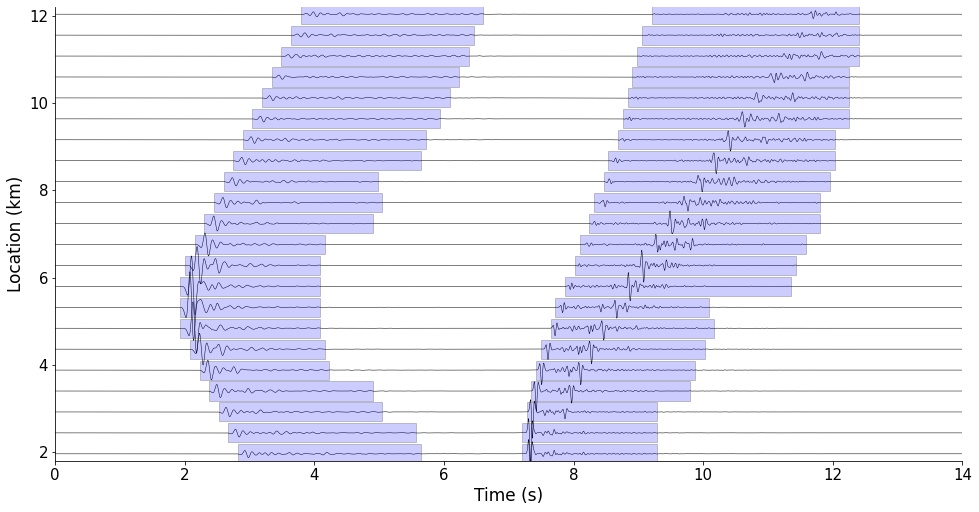

In [15]:
fname = 'Synthetic'

fig = cats.plot_traces(traces_clean, detection_true, fname, comp, gain=0.75, rsp=6, alpha=0.2)
fontsize = dict(labels=17, ticks=15)
figsize = 450
fig = fig.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=2, fig_size=figsize, invert_axes=False,
                                                        ylabel='Location (km)', xlabel='Time (s)', 
                                                       )
# hv.save(fig, f'../figures/synthetic_clean_{fname}_{comp}.png', dpi=300)
fig

:Overlay
   .Curve.I             :Curve   [Time]   (y)
   .Curve.II            :Curve   [Time]   (y)
   .Curve.III           :Curve   [Time]   (y)
   .Curve.IV            :Curve   [Time]   (y)
   .Curve.V             :Curve   [Time]   (y)
   .Curve.VI            :Curve   [Time]   (y)
   .Curve.VII           :Curve   [Time]   (y)
   .Curve.VIII          :Curve   [Time]   (y)
   .Curve.IX            :Curve   [Time]   (y)
   .Curve.X             :Curve   [Time]   (y)
   .Curve.XI            :Curve   [Time]   (y)
   .Curve.XII           :Curve   [Time]   (y)
   .Curve.XIII          :Curve   [Time]   (y)
   .Curve.XIV           :Curve   [Time]   (y)
   .Curve.XV            :Curve   [Time]   (y)
   .Curve.XVI           :Curve   [Time]   (y)
   .Curve.XVII          :Curve   [Time]   (y)
   .Curve.XVIII         :Curve   [Time]   (y)
   .Curve.XIX           :Curve   [Time]   (y)
   .Curve.XX            :Curve   [Time]   (y)
   .Curve.XXI           :Curve   [Time]   (y)
   .Curve.XXII          :Curve   [Time]   (y)
   .Curve.XXIII         :Curve   [Time]   (y)
   .Curve.XXIV          :Curve   [Time]   (y)
   .Curve.XXV           :Curve   [Time]   (y)
   .Curve.XXVI          :Curve   [Time]   (y)
   .Curve.XXVII         :Curve   [Time]   (y)
   .Curve.XXVIII        :Curve   [Time]   (y)
   .Curve.XXIX          :Curve   [Time]   (y)
   .Curve.XXX           :Curve   [Time]   (y)
   .Curve.XXXI          :Curve   [Time]   (y)
   .Curve.XXXII         :Curve   [Time]   (y)
   .Curve.XXXIII        :Curve   [Time]   (y)
   .Curve.XXXIV         :Curve   [Time]   (y)
   .Curve.XXXV          :Curve   [Time]   (y)
   .Curve.XXXVI         :Curve   [Time]   (y)
   .Curve.XXXVII        :Curve   [Time]   (y)
   .Curve.XXXVIII       :Curve   [Time]   (y)
   .Curve.XXXIX         :Curve   [Time]   (y)
   .Curve.XL            :Curve   [Time]   (y)
   .Curve.XLI           :Curve   [Time]   (y)
   .Curve.XLII          :Curve   [Time]   (y)
   .Curve.XLIII         :Curve   [Time]   (y)
   .Curve.XLIV          :Curve   [Time]   (y)
   .Curve.XLV           :Curve   [Time]   (y)
   .Curve.XLVI          :Curve   [Time]   (y)
   .Curve.XLVII         :Curve   [Time]   (y)
   .Curve.XLVIII        :Curve   [Time]   (y)
   .Curve.XLIX          :Curve   [Time]   (y)
   .Curve.L             :Curve   [Time]   (y)
   .Curve.LI            :Curve   [Time]   (y)
   .Curve.LII           :Curve   [Time]   (y)
   .Curve.LIII          :Curve   [Time]   (y)
   .Curve.LIV           :Curve   [Time]   (y)
   .Curve.LV            :Curve   [Time]   (y)
   .Curve.LVI           :Curve   [Time]   (y)
   .Curve.LVII          :Curve   [Time]   (y)
   .Curve.LVIII         :Curve   [Time]   (y)
   .Curve.LIX           :Curve   [Time]   (y)
   .Curve.LX            :Curve   [Time]   (y)
   .Curve.LXI           :Curve   [Time]   (y)
   .Curve.LXII          :Curve   [Time]   (y)
   .Curve.LXIII         :Curve   [Time]   (y)
   .Curve.LXIV          :Curve   [Time]   (y)
   .Curve.LXV           :Curve   [Time]   (y)
   .Curve.LXVI          :Curve   [Time]   (y)
   .Curve.LXVII         :Curve   [Time]   (y)
   .Curve.LXVIII        :Curve   [Time]   (y)
   .Curve.LXIX          :Curve   [Time]   (y)
   .Curve.LXX           :Curve   [Time]   (y)
   .Curve.LXXI          :Curve   [Time]   (y)
   .Curve.LXXII         :Curve   [Time]   (y)
   .Curve.LXXIII        :Curve   [Time]   (y)
   .Curve.LXXIV         :Curve   [Time]   (y)
   .Curve.LXXV          :Curve   [Time]   (y)
   .Curve.LXXVI         :Curve   [Time]   (y)
   .Curve.LXXVII        :Curve   [Time]   (y)
   .Curve.LXXVIII       :Curve   [Time]   (y)
   .Curve.LXXIX         :Curve   [Time]   (y)
   .Curve.LXXX          :Curve   [Time]   (y)
   .Curve.LXXXI         :Curve   [Time]   (y)
   .Curve.LXXXII        :Curve   [Time]   (y)
   .Curve.LXXXIII       :Curve   [Time]   (y)
   .Curve.LXXXIV        :Curve   [Time]   (y)
   .Curve.LXXXV         :Curve   [Time]   (y)
   .Curve.LXXXVI        :Curve   [Time]   (y)
   .Curve.LXXXVII       :Curve   [T
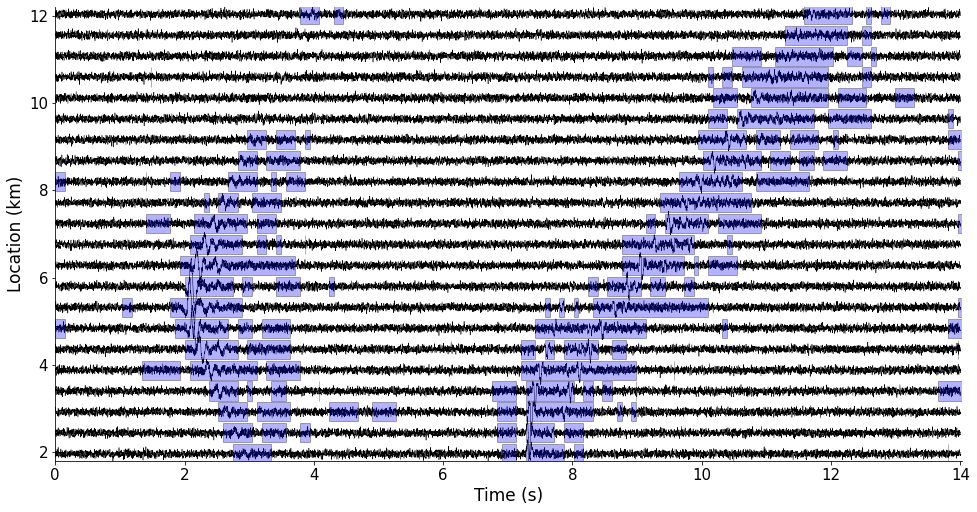

In [16]:
fig = cats.plot_traces(traces, detection_pred, fname, comp, gain=0.75, rsp=6, alpha=0.3)
fontsize = dict(labels=17, ticks=15)
figsize = 450
fig = fig.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=2, fig_size=figsize, invert_axes=False,
                                                        ylabel='Location (km)', xlabel='Time (s)')
# hv.save(fig, f'../figures/synthetic_pred_{fname}_{comp}_{noise_id}.png', dpi=300)
fig

:Overlay
   .Curve.I                 :Curve   [Time]   (y)
   .Curve.II                :Curve   [Time]   (y)
   .Curve.III               :Curve   [Time]   (y)
   .Curve.IV                :Curve   [Time]   (y)
   .Curve.V                 :Curve   [Time]   (y)
   .Curve.VI                :Curve   [Time]   (y)
   .Curve.VII               :Curve   [Time]   (y)
   .Curve.VIII              :Curve   [Time]   (y)
   .Curve.IX                :Curve   [Time]   (y)
   .Curve.X                 :Curve   [Time]   (y)
   .Curve.XI                :Curve   [Time]   (y)
   .Curve.XII               :Curve   [Time]   (y)
   .Curve.XIII              :Curve   [Time]   (y)
   .Curve.XIV               :Curve   [Time]   (y)
   .Curve.XV                :Curve   [Time]   (y)
   .Curve.XVI               :Curve   [Time]   (y)
   .Curve.XVII              :Curve   [Time]   (y)
   .Curve.XVIII             :Curve   [Time]   (y)
   .Curve.XIX               :Curve   [Time]   (y)
   .Curve.XX                :Curve   [Time]   (y)
   .Curve.XXI               :Curve   [Time]   (y)
   .Curve.XXII              :Curve   [Time]   (y)
   .Curve.XXIII             :Curve   [Time]   (y)
   .Curve.XXIV              :Curve   [Time]   (y)
   .Curve.XXV               :Curve   [Time]   (y)
   .Curve.XXVI              :Curve   [Time]   (y)
   .Curve.XXVII             :Curve   [Time]   (y)
   .Curve.XXVIII            :Curve   [Time]   (y)
   .Curve.XXIX              :Curve   [Time]   (y)
   .Curve.XXX               :Curve   [Time]   (y)
   .Curve.XXXI              :Curve   [Time]   (y)
   .Curve.XXXII             :Curve   [Time]   (y)
   .Curve.XXXIII            :Curve   [Time]   (y)
   .Curve.XXXIV             :Curve   [Time]   (y)
   .Curve.XXXV              :Curve   [Time]   (y)
   .Curve.XXXVI             :Curve   [Time]   (y)
   .Curve.XXXVII            :Curve   [Time]   (y)
   .Curve.XXXVIII           :Curve   [Time]   (y)
   .Curve.XXXIX             :Curve   [Time]   (y)
   .Curve.XL                :Curve   [Time]   (y)
   .Curve.XLI               :Curve   [Time]   (y)
   .Curve.XLII              :Curve   [Time]   (y)
   .Curve.XLIII             :Curve   [Time]   (y)
   .Curve.XLIV              :Curve   [Time]   (y)
   .Curve.XLV               :Curve   [Time]   (y)
   .Curve.XLVI              :Curve   [Time]   (y)
   .Curve.XLVII             :Curve   [Time]   (y)
   .Curve.XLVIII            :Curve   [Time]   (y)
   .Curve.XLIX              :Curve   [Time]   (y)
   .Curve.L                 :Curve   [Time]   (y)
   .Curve.LI                :Curve   [Time]   (y)
   .Curve.LII               :Curve   [Time]   (y)
   .Curve.LIII              :Curve   [Time]   (y)
   .Curve.LIV               :Curve   [Time]   (y)
   .Curve.LV                :Curve   [Time]   (y)
   .Curve.LVI               :Curve   [Time]   (y)
   .Curve.LVII              :Curve   [Time]   (y)
   .Curve.LVIII             :Curve   [Time]   (y)
   .Curve.LIX               :Curve   [Time]   (y)
   .Curve.LX                :Curve   [Time]   (y)
   .Curve.LXI               :Curve   [Time]   (y)
   .Curve.LXII              :Curve   [Time]   (y)
   .Curve.LXIII             :Curve   [Time]   (y)
   .Curve.LXIV              :Curve   [Time]   (y)
   .Curve.LXV               :Curve   [Time]   (y)
   .Curve.LXVI              :Curve   [Time]   (y)
   .Curve.LXVII             :Curve   [Time]   (y)
   .Curve.LXVIII            :Curve   [Time]   (y)
   .Curve.LXIX              :Curve   [Time]   (y)
   .Curve.LXX               :Curve   [Time]   (y)
   .Curve.LXXI              :Curve   [Time]   (y)
   .Curve.LXXII             :Curve   [Time]   (y)
   .Curve.LXXIII            :Curve   [Time]   (y)
   .Curve.LXXIV             :Curve   [Time]   (y)
   .Curve.LXXV              :Curve   [Time]   (y)
   .Curve.LXXVI             :Curve   [Time]   (y)
   .Curve.LXXVII            :Curve   [Time]   (y)
   .Curve.LXXVIII           :Curve   [Time]   (y)
   .Curve.LXXIX             :Curve   [Time]   (y)
   .Curve.LXXX              :Curve   [Tim
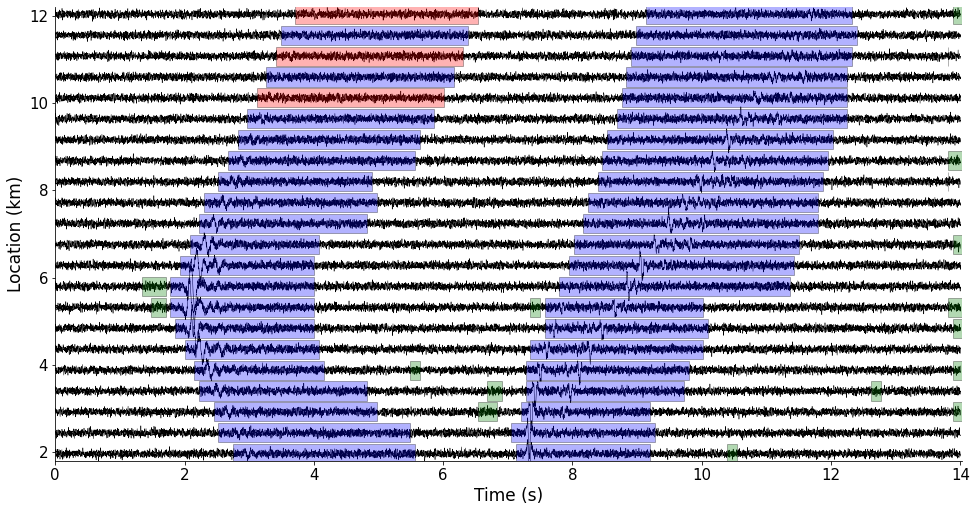

In [16]:
fig = cats.plot_traces(traces, detection_labels, fname, comp, gain=0.75, rsp=6, alpha=0.3)
fontsize = dict(labels=17, ticks=15)
figsize = 450
fig = fig.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=2, fig_size=figsize, invert_axes=False,
                                                        ylabel='Location (km)', xlabel='Time (s)')
# hv.save(fig, f'../figures/synthetic_labels_{fname}_{comp}_{noise_id}.png', dpi=300)
fig

In [17]:
print(report.format(R[..., comps[comp], 1].sum(), R[..., comps[comp], 2].sum(), 
                    R[..., comps[comp], 3].sum(), R[..., comps[comp], 0].sum()))

True Positive = 234	False Positive = 108
True Negative = 342	False Negative = 20


# Real boreholde data

In [19]:
import glob
from pathlib import Path
from scipy.io import loadmat, savemat, wavfile
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

In [20]:
data_dir = Path("C:/Users/seraf/OneDrive - ualberta.ca/Documents/SampleData")
data_folder = data_dir / 'BoreholeData_reformat'
data_paths = sorted(list(data_folder.rglob("*.pkl")))

In [21]:
filenames = []
Data = {}
Headers = {}

for i, fi in enumerate(tqdm(data_paths)):
    filename = fi.name.split('.')[0]
    filenames.append(filename)
    Di = api.utils.read_dict(fi)
    Headers[filename] = Di['hdrc']
    dt = Di['hdrc']['delta']
    time = np.arange(0, Di['data'].shape[-1] * dt, dt)
    Data[filename] = xr.DataArray(np.nan_to_num(Di['data']).swapaxes(0, 1), 
                                  dims=("Location", "Component", "Time"), 
                                  coords={"Location" : Di['hdrc']['stdp'], 
                                          "Component": ['X', 'Y', 'Z'], 
                                          "Time" : time})

  0%|          | 0/9 [00:00<?, ?it/s]

In [22]:
catsdet = cats.CATSDetector(dt_sec=dt,
                            stft_window_sec=('hann', 0.1),
                            stft_overlap=0.75,
                            stft_nfft=512,
                            minSNR=4.0,
                            stationary_frame_sec=10.0,
                            cluster_size_t_sec=0.08,
                            cluster_size_f_Hz=30.,
                            cluster_distance_t_sec=0.05,
                            cluster_distance_f_Hz=10.,
                            min_t_separation_sec=0.1,
                            clustering_with_SNR=True,
                            clustering_multitrace=True,
                            cluster_size_trace=2,
                            cluster_distance_trace=2,
                            date_Q=0.95,
                            date_detection_mode=True,
                            stft_backend='ssqueezepy')
print(f"{catsdet.stationary_frame_len = }")
print(f"{catsdet.min_t_separation_len = }")
print(f"{catsdet.cluster_size_t_len = }")
print(f"{catsdet.cluster_size_f_len = }")
print(f"{catsdet.cluster_distance_t_len = }")
print(f"{catsdet.cluster_distance_f_len = }")

catsdet.stationary_frame_len = 400
catsdet.min_t_separation_len = 4
catsdet.cluster_size_t_len = 3
catsdet.cluster_size_f_len = 3
catsdet.cluster_distance_t_len = 2
catsdet.cluster_distance_f_len = 1


In [23]:
Detection = {}

name = "CATS"
Detection[name] = {}
for fi, di in tqdm(Data.items(), desc=name):
    res = catsdet.detect(di.values)
    stft_time, detection = res.stft_time, res.detection
    Detection[name][fi] = xr.DataArray(detection, 
                                       dims=di.dims,
                                       coords={"Component" : di.coords["Component"],
                                               "Location" : di.coords["Location"],
                                               "Time" : stft_time})

CATS:   0%|          | 0/9 [00:00<?, ?it/s]

:Overlay
   .Curve.I             :Curve   [Time]   (y)
   .Curve.II            :Curve   [Time]   (y)
   .Curve.III           :Curve   [Time]   (y)
   .Curve.IV            :Curve   [Time]   (y)
   .Curve.V             :Curve   [Time]   (y)
   .Curve.VI            :Curve   [Time]   (y)
   .Curve.VII           :Curve   [Time]   (y)
   .Curve.VIII          :Curve   [Time]   (y)
   .Curve.IX            :Curve   [Time]   (y)
   .Curve.X             :Curve   [Time]   (y)
   .Curve.XI            :Curve   [Time]   (y)
   .Curve.XII           :Curve   [Time]   (y)
   .Curve.XIII          :Curve   [Time]   (y)
   .Curve.XIV           :Curve   [Time]   (y)
   .Curve.XV            :Curve   [Time]   (y)
   .Curve.XVI           :Curve   [Time]   (y)
   .Curve.XVII          :Curve   [Time]   (y)
   .Curve.XVIII         :Curve   [Time]   (y)
   .Curve.XIX           :Curve   [Time]   (y)
   .Curve.XX            :Curve   [Time]   (y)
   .Curve.XXI           :Curve   [Time]   (y)
   .Curve.XXII          :Curve   [Time]   (y)
   .Curve.XXIII         :Curve   [Time]   (y)
   .Curve.XXIV          :Curve   [Time]   (y)
   .Curve.XXV           :Curve   [Time]   (y)
   .Curve.XXVI          :Curve   [Time]   (y)
   .Curve.XXVII         :Curve   [Time]   (y)
   .Curve.XXVIII        :Curve   [Time]   (y)
   .Curve.XXIX          :Curve   [Time]   (y)
   .Curve.XXX           :Curve   [Time]   (y)
   .Rectangles.Detected :Rectangles   [x0,y0,x1,y1]
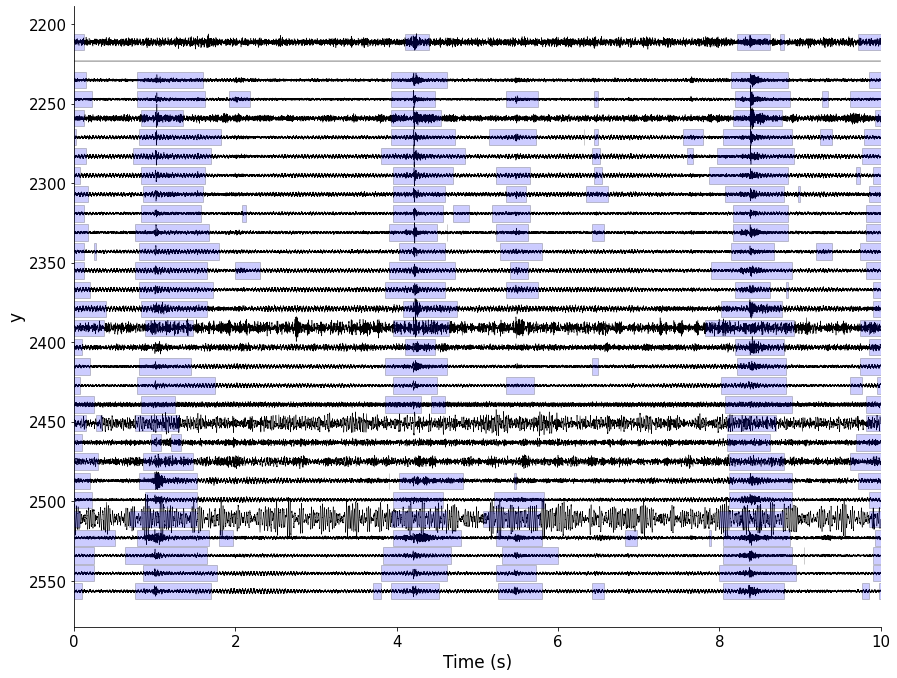

In [24]:
fname = 'File137206'
comp = 'Z'
figure = cats.plot_traces(Data, Detection['CATS'], fname=fname, comp=comp, gain=0.5, alpha=0.2)
fontsize = dict(labels=17, ticks=15)
figure = figure.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=1.3, invert_yaxis=True)
figure

:Overlay
   .Curve.I             :Curve   [Time]   (y)
   .Curve.II            :Curve   [Time]   (y)
   .Curve.III           :Curve   [Time]   (y)
   .Curve.IV            :Curve   [Time]   (y)
   .Curve.V             :Curve   [Time]   (y)
   .Curve.VI            :Curve   [Time]   (y)
   .Curve.VII           :Curve   [Time]   (y)
   .Curve.VIII          :Curve   [Time]   (y)
   .Curve.IX            :Curve   [Time]   (y)
   .Curve.X             :Curve   [Time]   (y)
   .Curve.XI            :Curve   [Time]   (y)
   .Curve.XII           :Curve   [Time]   (y)
   .Curve.XIII          :Curve   [Time]   (y)
   .Curve.XIV           :Curve   [Time]   (y)
   .Curve.XV            :Curve   [Time]   (y)
   .Curve.XVI           :Curve   [Time]   (y)
   .Curve.XVII          :Curve   [Time]   (y)
   .Curve.XVIII         :Curve   [Time]   (y)
   .Curve.XIX           :Curve   [Time]   (y)
   .Curve.XX            :Curve   [Time]   (y)
   .Curve.XXI           :Curve   [Time]   (y)
   .Curve.XXII          :Curve   [Time]   (y)
   .Curve.XXIII         :Curve   [Time]   (y)
   .Curve.XXIV          :Curve   [Time]   (y)
   .Curve.XXV           :Curve   [Time]   (y)
   .Curve.XXVI          :Curve   [Time]   (y)
   .Curve.XXVII         :Curve   [Time]   (y)
   .Curve.XXVIII        :Curve   [Time]   (y)
   .Curve.XXIX          :Curve   [Time]   (y)
   .Curve.XXX           :Curve   [Time]   (y)
   .Rectangles.Detected :Rectangles   [x0,y0,x1,y1]
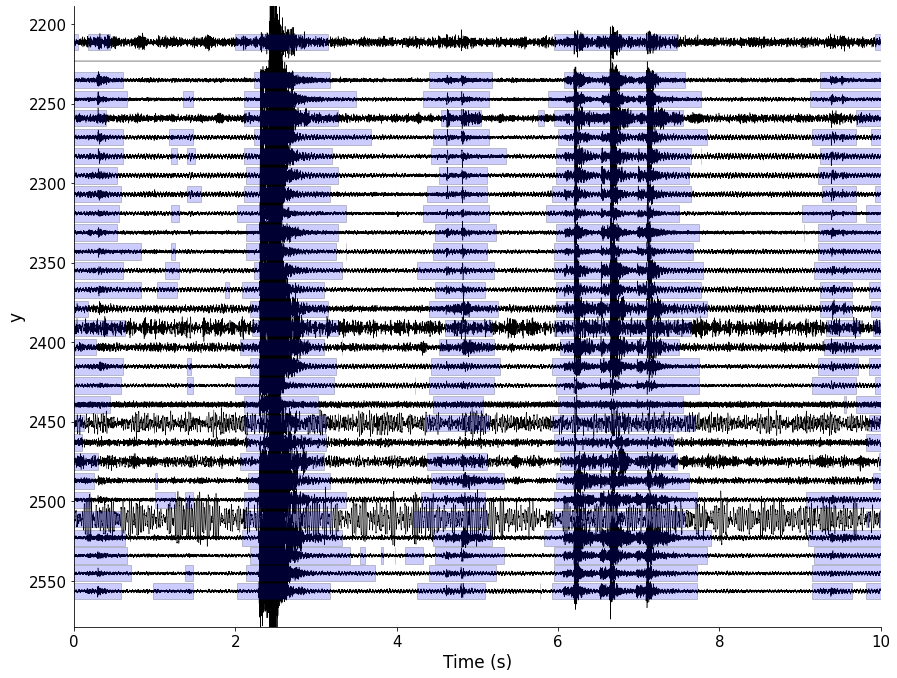

In [25]:
fname = 'File137203'
comp = 'Z'
figure = cats.plot_traces(Data, Detection['CATS'], fname=fname, comp=comp, gain=5, alpha=0.2)
fontsize = dict(labels=17, ticks=15)
figure = figure.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=1.3, invert_yaxis=True)
figure

In [22]:
hv.save(figure, f"../figures/WellData_{fname}_{comp}.png", dpi=300)